In [148]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier, plot_tree
import sklearn
import warnings
%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

In [150]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/car.data")

In [151]:
df.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [152]:
df.columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class values"]


In [153]:
df['doors'] = df['doors'].replace(['5more'], '5')
df['persons'] = df['persons'].replace(['more'], '4')


# Convert categorical features to category type and encode them

In [154]:
for col in ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']:
    df[col] = df[col].astype('category')


# Convert categories to codes

In [155]:
for col in ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']:
    df[col] = df[col].cat.codes


# One-hot encode features

In [156]:
df = pd.get_dummies(df, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

# Drop unnecessary columns

In [157]:
df = df.drop(['buying_3', 'maint_3', 'doors_3', 'persons_1', 'lug_boot_2', 'safety_2'], axis=1)

# Encode target variable

In [158]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['class values'] = labelencoder.fit_transform(df['class values'])

In [159]:
x = df.drop(["class values"], axis=1)
y = df["class values"]

# Split into 70% train, 15% validation, and 15% test sets

In [160]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Model 1: Decision Tree Classifier


In [161]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier()

In [162]:
y_pred_train = clf.predict(x_train)
y_pred_val = clf.predict(x_val)
y_pred_test = clf.predict(x_test)


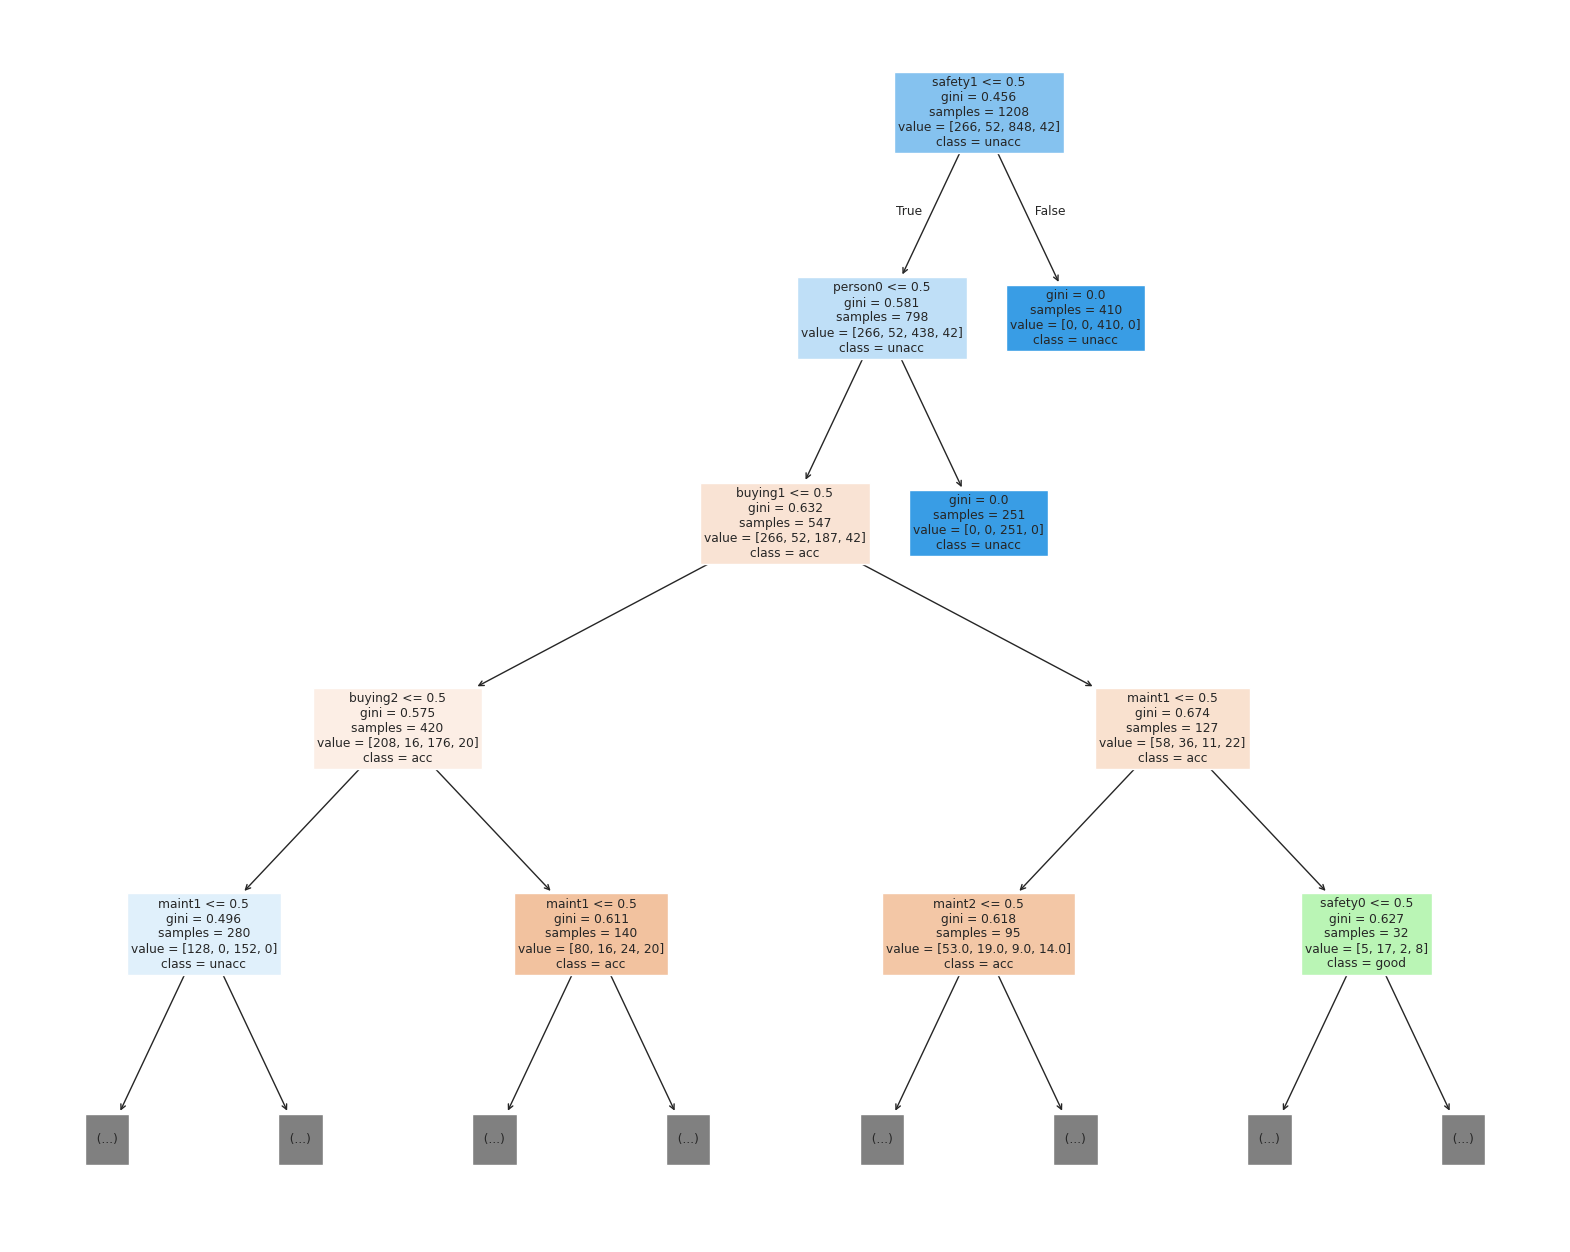

In [163]:
plt.figure(figsize=(20, 16))
f_n = ['buying0', 'buying1', 'buying2', 'maint0', 'maint1', 'maint2', 'doors0', 'doors1', 'doors2', 'person0', 'logboot0', 'logboot1', 'safety0', 'safety1']
c_n = ['acc', 'good', 'unacc', 'vgood']
plot_tree(clf, filled=True, class_names=c_n, feature_names=f_n, max_depth=4)
plt.show()

# Predictions for Decision Tree

In [164]:
def confusion_matrix(y_true, y_pred, labels=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))

    cm = np.zeros((len(labels), len(labels)), dtype=int)

    label_to_index = {label: idx for idx, label in enumerate(labels)}

    for true_label, pred_label in zip(y_true, y_pred):
        true_idx = label_to_index[true_label]
        pred_idx = label_to_index[pred_label]
        cm[true_idx, pred_idx] += 1

    return cm


In [165]:
print('Training data confusion matrix\n', confusion_matrix(y_train, y_pred_train))
print('\nValidation data confusion matrix\n', confusion_matrix(y_val, y_pred_val))
print('\nTesting data confusion matrix\n', confusion_matrix(y_test, y_pred_test))

Training data confusion matrix
 [[266   0   0   0]
 [  2  50   0   0]
 [ 15   3 830   0]
 [  0   0   0  42]]

Validation data confusion matrix
 [[ 62   0   3   1]
 [  0   3   0   2]
 [  3   0 175   0]
 [  0   0   0  10]]

Testing data confusion matrix
 [[ 47   3   1   1]
 [  0   9   0   3]
 [  3   0 180   0]
 [  0   2   0  11]]


In [166]:
def precision_recall_f1(cm):
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f1 = 2 * (precision * recall) / (precision + recall)

    accuracy = np.sum(np.diag(cm)) / np.sum(cm)

    return precision, recall, f1, accuracy

def classification_report(y_true, y_pred, labels=None):
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))

    cm = confusion_matrix(y_true, y_pred, labels)

    precision, recall, f1, accuracy = precision_recall_f1(cm)

    report = "               precision    recall  f1-score   support\n\n"

    for idx, label in enumerate(labels):
        report += f"{label:>10}       {precision[idx]:.2f}      {recall[idx]:.2f}      {f1[idx]:.2f}       {np.sum(cm[idx]):>3}\n"

    macro_avg_precision = np.mean(precision)
    macro_avg_recall = np.mean(recall)
    macro_avg_f1 = np.mean(f1)
    report += f"\n    accuracy                           {accuracy:.2f}      {len(y_true)}\n"
    report += f"   macro avg       {macro_avg_precision:.2f}      {macro_avg_recall:.2f}      {macro_avg_f1:.2f}      {len(y_true)}\n"

    return report


In [167]:
print('Training data Classification Report\n', classification_report(y_train, y_pred_train))
print('\nValidation data Classification Report\n', classification_report(y_val, y_pred_val))
print('\nTesting data Classification Report\n', classification_report(y_test, y_pred_test))

Training data Classification Report
                precision    recall  f1-score   support

         0       0.94      1.00      0.97       266
         1       0.94      0.96      0.95        52
         2       1.00      0.98      0.99       848
         3       1.00      1.00      1.00        42

    accuracy                           0.98      1208
   macro avg       0.97      0.99      0.98      1208


Validation data Classification Report
                precision    recall  f1-score   support

         0       0.95      0.94      0.95        66
         1       1.00      0.60      0.75         5
         2       0.98      0.98      0.98       178
         3       0.77      1.00      0.87        10

    accuracy                           0.97      259
   macro avg       0.93      0.88      0.89      259


Testing data Classification Report
                precision    recall  f1-score   support

         0       0.94      0.90      0.92        52
         1       0.64      0.75 

In [168]:
def accuracy_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    corr_pred = np.sum(y_true == y_pred)

    total_pred = len(y_true)

    accuracy = corr_pred / total_pred

    return accuracy

In [169]:
print('Training data accuracy score:', accuracy_score(y_train, y_pred_train))
print('Validation data accuracy score:', accuracy_score(y_val, y_pred_val))
print('Testing data accuracy score:', accuracy_score(y_test, y_pred_test))

Training data accuracy score: 0.9834437086092715
Validation data accuracy score: 0.9652509652509652
Testing data accuracy score: 0.95


In [170]:
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
y_score = clf.predict_proba(x_test)


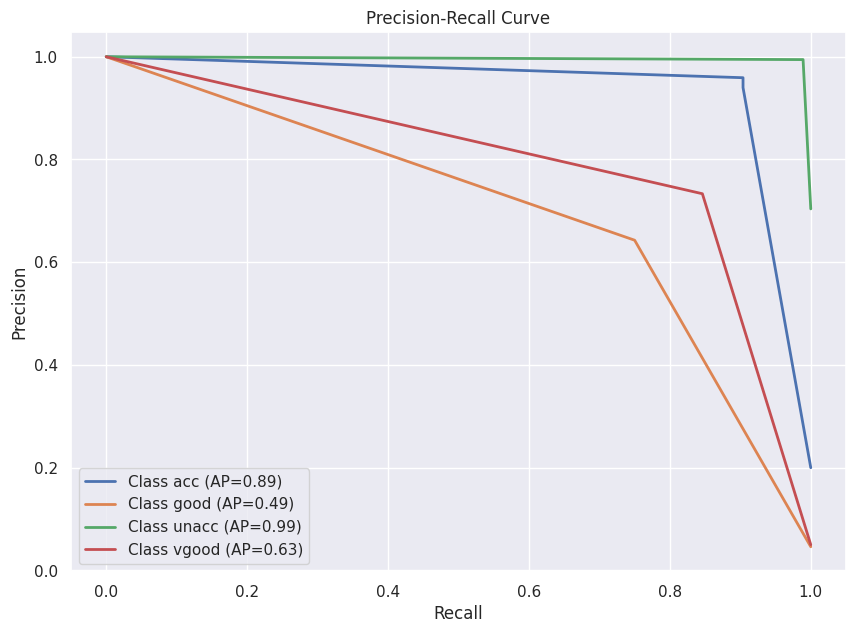

In [171]:
plt.figure(figsize=(10, 7))
for i in range(4):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    average_precision = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {labelencoder.inverse_transform([i])[0]} (AP={average_precision:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Model 2: XGBoost Classifier


In [172]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
clf_xgb.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [173]:

y_pred_train_xgb = clf_xgb.predict(x_train)
y_pred_val_xgb = clf_xgb.predict(x_val)
y_pred_test_xgb = clf_xgb.predict(x_test)

In [174]:

print("=== XGBoost Classifier ===")
print('Training data accuracy score:', accuracy_score(y_train, y_pred_train_xgb))
print('Validation data accuracy score:', accuracy_score(y_val, y_pred_val_xgb))
print('Testing data accuracy score:', accuracy_score(y_test, y_pred_test_xgb))
print('\nTesting data Classification Report\n', classification_report(y_test, y_pred_test_xgb))


=== XGBoost Classifier ===
Training data accuracy score: 0.9834437086092715
Validation data accuracy score: 0.9768339768339769
Testing data accuracy score: 0.9615384615384616

Testing data Classification Report
                precision    recall  f1-score   support

         0       0.94      0.92      0.93        52
         1       0.79      0.92      0.85        12
         2       0.98      0.99      0.99       183
         3       0.91      0.77      0.83        13

    accuracy                           0.96      260
   macro avg       0.90      0.90      0.90      260



In [175]:
print('Training data confusion matrix\n', confusion_matrix(y_train, y_pred_train_xgb))
print('\nValidation data confusion matrix\n', confusion_matrix(y_val, y_pred_val_xgb))
print('\nTesting data confusion matrix\n', confusion_matrix(y_test, y_pred_test_xgb))

Training data confusion matrix
 [[261   2   3   0]
 [  0  49   3   0]
 [ 12   0 836   0]
 [  0   0   0  42]]

Validation data confusion matrix
 [[ 62   0   3   1]
 [  0   5   0   0]
 [  2   0 176   0]
 [  0   0   0  10]]

Testing data confusion matrix
 [[ 48   1   3   0]
 [  0  11   0   1]
 [  2   0 181   0]
 [  1   2   0  10]]


In [176]:
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
y_score_xgb = clf_xgb.predict_proba(x_test)

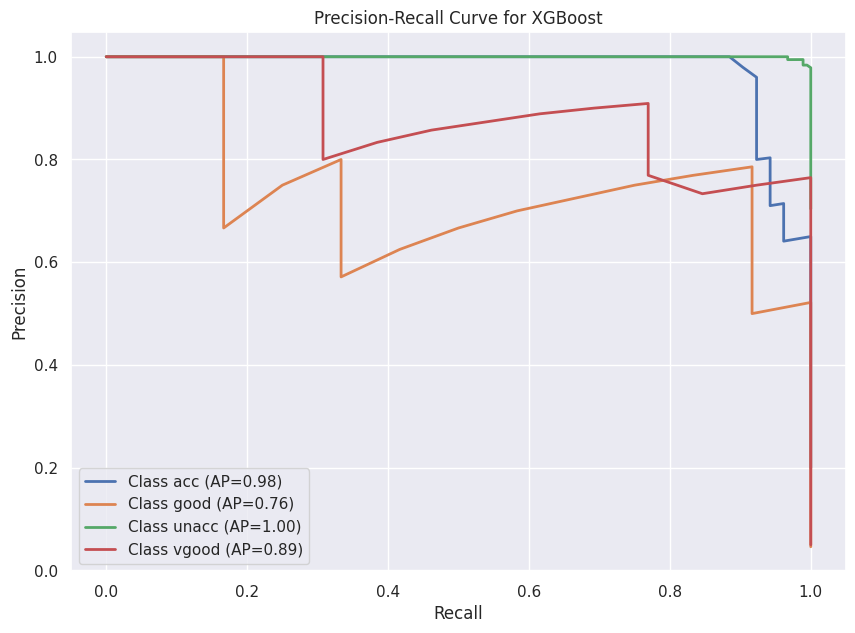

In [177]:
plt.figure(figsize=(10, 7))
for i in range(4):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score_xgb[:, i])
    average_precision = average_precision_score(y_test_binarized[:, i], y_score_xgb[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {labelencoder.inverse_transform([i])[0]} (AP={average_precision:.2f})')


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for XGBoost")
plt.legend(loc="best")
plt.show()
